In [ ]:
# Clean and reset data to original for 
# re-running the notebook from the start

import os
import shutil
os.chdir('/home/sarah/FourthBrain/Midterm')
path = './Data/train/validation'
files = os.listdir('./Data/train/validation')
for file in files:
    file = os.path.join(path, file)
    shutil.move(file, './Data/train/train')

In [ ]:
pwd

In [3]:
import numpy as np
import pandas as pd

# bring in training csv
train_csv = pd.read_csv('./Data/train/train.csv')
train_csv.head()

,filename,opacity,diabetic retinopathy,glaucoma,macular edema,macular degeneration,retinal vascular occlusion,normal
0,c24a1b14d253.jpg,0,0,0,0,0,1,0
1,9ee905a41651.jpg,0,0,0,0,0,1,0
2,3f58d128caf6.jpg,0,0,1,0,0,0,0
3,4ce6599e7b20.jpg,1,0,0,0,1,0,0
4,0def470360e4.jpg,1,0,0,0,1,0,0


In [4]:
train_csv.shape

(3435, 8)

In [5]:
# Drop columns we aren't using
train_csv = train_csv.drop(labels=['opacity', 'macular edema',
                                   'macular degeneration',
                                   'retinal vascular occlusion'],
                           axis='columns')
train_csv.shape

(3435, 4)

In [6]:
train_csv.head()

,filename,diabetic retinopathy,glaucoma,normal
0,c24a1b14d253.jpg,0,0,0
1,9ee905a41651.jpg,0,0,0
2,3f58d128caf6.jpg,0,1,0
3,4ce6599e7b20.jpg,0,0,0
4,0def470360e4.jpg,0,0,0


In [7]:
# !!!!! TODO: Determine what to do with images that belong to no category
conditions = [
    (train_csv['diabetic retinopathy'] == 1),
    (train_csv['diabetic retinopathy'] == 1),
    (train_csv['diabetic retinopathy'] == 1),
    (train_csv['diabetic retinopathy'] == 0) 
    & (train_csv['glaucoma'] == 0)
    & (train_csv['normal'] == 0),
]
values = [0, 0, 0, 1]
train_csv['other'] = np.select(conditions, values)
train_csv.head()

,filename,diabetic retinopathy,glaucoma,normal,other
0,c24a1b14d253.jpg,0,0,0,1
1,9ee905a41651.jpg,0,0,0,1
2,3f58d128caf6.jpg,0,1,0,0
3,4ce6599e7b20.jpg,0,0,0,1
4,0def470360e4.jpg,0,0,0,1


In [8]:
# Shuffle the data
train_csv = train_csv.sample(frac=1)
print(train_csv.shape)

(3435, 5)


In [9]:
train_csv.describe()

,diabetic retinopathy,glaucoma,normal,other
count,3435.000000,3435.000000,3435.000000,3435.000000
mean,0.219796,0.173799,0.152838,0.459098
std,0.414169,0.378992,0.359884,0.498397
min,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,1.000000
max,1.000000,1.000000,1.000000,1.000000


array([[<AxesSubplot:title={'center':'diabetic retinopathy'}>,
        <AxesSubplot:title={'center':'glaucoma'}>],
       [<AxesSubplot:title={'center':'normal'}>,
        <AxesSubplot:title={'center':'other'}>]], dtype=object)

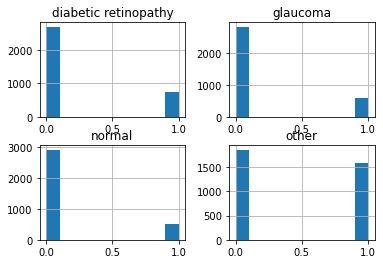

In [10]:
train_csv.hist()

In [11]:
import math
test_portion = math.floor(.3 * train_csv.shape[0])

In [12]:
test_csv = train_csv[0:test_portion]
test_csv.shape

(1030, 5)

In [13]:
test_csv.head()

,filename,diabetic retinopathy,glaucoma,normal,other
1031,c7f7985433a8.jpg,0,1,0,0
1509,5c79ad99f036.jpg,0,0,0,1
1603,3ebf8794ed00.jpg,0,1,0,0
355,7f50931443a3.jpg,1,0,0,0
2103,75454149be0b.jpg,0,0,0,1


In [14]:
train_csv = train_csv[test_portion:]
train_csv.shape

(2405, 5)

In [15]:
import os
files = os.listdir('./Data/train/train/')
print(len(files))

3437


In [16]:
validation_images = test_csv['filename']
for file in validation_images:
    file = os.path.join('./Data/train/train', file)
    #print(file)
    shutil.move(file, '/home/sarah/FourthBrain/Midterm/Data/train/validation')

In [17]:
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import *
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping
from tensorflow.keras import backend as keras
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
import scipy.misc as sc

In [18]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=0.2,
                                                 width_shift_range=0.05,
                                                 height_shift_range=0.05,
                                                 zoom_range=[0.7,1],
                                                 horizontal_flip=True,
                                                 vertical_flip=True)

In [19]:
def sad_model(pretrained_weights=None, input_size=(224, 224, 3)):
    inputs = tf.keras.Input(shape=input_size)
    x = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    x = Conv2D(64, 3, activation='relu', padding='same')(x)
    x = MaxPool2D()(x)
    
    flat = Flatten()(x)
    dense = Dense(1*1*512, activation='relu')(flat)
    dropout = Dropout(0.5)(dense)
    
    dense = Dense(4096, activation='relu')(dense)
    dropout = Dropout(0.5)(dense)
    
    dense_last = Dense(4, activation='relu')(dropout)
    
    soft = Softmax()(dense_last)
    
    model = tf.keras.Model(inputs=inputs, outputs=soft)
    
    model.compile(optimizer=Adam(lr=1e-5), loss='categorical_crossentropy', metrics='accuracy')
    
    if (pretrained_weights):
        model=keras.models.load_model(pretrained_weights)
    
    return model

In [20]:
model = sad_model()
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
conv2d (Conv2D)              (None, 224, 224, 64)      1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 224, 224, 64)      36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 64)      0         
_________________________________________________________________
flatten (Flatten)            (None, 802816)            0         
_________________________________________________________________
dense (Dense)                (None, 512)               411042304 
_________________________________________________________________
dense_1 (Dense)              (None, 4096)              210124

In [21]:
import datetime
%load_ext tensorboard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [22]:
columns = ['diabetic retinopathy', 'glaucoma', 'normal', 'other']
train_gen = datagen.flow_from_dataframe(directory = './Data/train/train',
                                        dataframe = train_csv,
                                        x_col = 'filename',
                                        y_col = columns,
                                        target_size=(224,224),
                                        batch_size=5,
                                        rescale=1./255,
                                        class_mode='other',
                                       )

Found 2405 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.9/logging/__init__.py", line 1079, in emit
    msg = self.format(record)
  File "/usr/lib/python3.9/logging/__init__.py", line 923, in format
    return fmt.format(record)
  File "/usr/lib/python3.9/logging/__init__.py", line 659, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.9/logging/__init__.py", line 363, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3.9/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/usr/lib/py

In [23]:
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rotation_range=0,
                                                 width_shift_range=0.0,
                                                 height_shift_range=0.0,
                                                 horizontal_flip=False,
                                                 vertical_flip=False)
columns = ['diabetic retinopathy', 'glaucoma', 'normal', 'other']
test_gen = datagen.flow_from_dataframe(directory = './Data/train/validation/',
                                        dataframe = test_csv,
                                        x_col = 'filename',
                                        y_col = columns,
                                        target_size=(224,224),
                                        batch_size=5,
                                        rescale=1./255,
                                        class_mode='other',
                                       )

Found 1030 validated image filenames.


--- Logging error ---
Traceback (most recent call last):
  File "/usr/lib/python3.9/logging/__init__.py", line 1079, in emit
    msg = self.format(record)
  File "/usr/lib/python3.9/logging/__init__.py", line 923, in format
    return fmt.format(record)
  File "/usr/lib/python3.9/logging/__init__.py", line 659, in format
    record.message = record.getMessage()
  File "/usr/lib/python3.9/logging/__init__.py", line 363, in getMessage
    msg = msg % self.args
TypeError: not all arguments converted during string formatting
Call stack:
  File "/usr/lib/python3.9/runpy.py", line 197, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "/usr/lib/python3.9/runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "/usr/lib/python3.9/site-packages/ipykernel_launcher.py", line 16, in <module>
    app.launch_new_instance()
  File "/usr/lib/python3.9/site-packages/traitlets/config/application.py", line 845, in launch_instance
    app.start()
  File "/usr/lib/py

In [24]:
import time
now = str(time.time())
checkpoint = now + 'vgg16.hdf5'
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(checkpoint, monitor='loss',verbose=1, save_best_only=True)
early_stopping = EarlyStopping(monitor='val_accuracy', min_delta=0, patience=20, verbose=1, mode='auto')
fitting = model.fit_generator(train_gen,
                    steps_per_epoch=10,
                    epochs=100,
                    verbose=1, 
                    validation_data=test_gen,
                    validation_steps = 10,
                    callbacks=[tensorboard_callback, model_checkpoint, early_stopping])

/usr/lib/python3.9/site-packages/tensorflow/python/keras/engine/training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/100
10/10 [==============================] - 20s 2s/step - loss: 5.1018 - accuracy: 0.2772 - val_loss: 1.4140 - val_accuracy: 0.2600

Epoch 00001: loss improved from inf to 4.96571, saving model to 1608429073.0689325vgg16.hdf5
Epoch 2/100
10/10 [==============================] - 18s 2s/step - loss: 1.3352 - accuracy: 0.2314 - val_loss: 1.4140 - val_accuracy: 0.1600

Epoch 00002: loss improved from 4.96571 to 1.35862, saving model to 1608429073.0689325vgg16.hdf5
Epoch 3/100
10/10 [==============================] - 19s 2s/step - loss: 1.3913 - accuracy: 0.2472 - val_loss: 1.3863 - val_accuracy: 0.2400

Epoch 00003: loss did not improve from 1.35862
Epoch 4/100
10/10 [==============================] - 18s 2s/step - loss: 1.7433 - accuracy: 0.2041 - val_loss: 1.3863 - val_accuracy: 0.1200

Epoch 00004: loss did not improve from 1.35862
Epoch 5/100
10/10 [==============================] - 17s 2s/step - loss: 1.5768 - accuracy: 0.1381 - val_loss: 1.3863 - val_accuracy: 0.1600

Epoch 

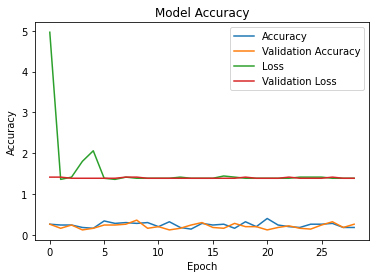

In [25]:
import matplotlib.pyplot as plt

plt.plot(fitting.history['accuracy'])
plt.plot(fitting.history['val_accuracy'])
plt.plot(fitting.history['loss'])
plt.plot(fitting.history['val_loss'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Accuracy', 'Validation Accuracy', 'Loss', 'Validation Loss'])
plt.show()

In [27]:
Y_pred = model.predict(test_gen)

In [ ]:
from sklearn.metrics import confusion_matrix

y_pred = np.argmax(Y_pred, axis=1)
print('Confusion Matrix')
target_names = ['diabetic retinopathy', 'glaucoma', 'normal', 'other']
print(confusion_matrix(test_gen.classes, y_pred, target_name=target_names))

In [28]:
print(Y_pred)

[[0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 ...
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]
 [0.25 0.25 0.25 0.25]]
